# Question 3:

### *Is there a correlation between product category and customer region? (i.e. do certain categories of product sell better/worse depending on the region?)*

## Define Hypotheses


*    ***Null Hypothesis:*** There is no correlation between product category and customer region.
*    ***Alternate Hypothesis:*** There is a statistically significant correlation between product category and customer region.

For reference, the relational structure of this dataset is provided below.
<img src='Northwind_ERD.png'>

## Importing Data & Libraries

In [1]:
# For SQL & dataframes
import pandas as pd
import sqlite3

# For math & statistics
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

# For graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('Employee',), ('Category',), ('Customer',), ('Shipper',), ('Supplier',), ('Order',), ('Product',), ('OrderDetail',), ('CustomerCustomerDemo',), ('CustomerDemographic',), ('Region',), ('Territory',), ('EmployeeTerritory',)]


### Make some SQL queries to examine the data

In [3]:
c.execute("""
          SELECT c.Id as CustomerId, c.Country, c.Region, cat.CategoryName, 
          p.Id as ProductId, p.ProductName, od.UnitPrice, od.Quantity, 
          (od.Quantity*od.UnitPrice*(1-od.Discount)) as OrderPrice, o.Id as OrderId
          FROM OrderDetail od
          JOIN 'Order' o ON od.OrderId = o.Id
          JOIN Customer c ON o.CustomerId = c.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON p.CategoryId = cat.Id
          ORDER BY cat.CategoryName;
          """)
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
display(df.head())
df.info()

,CustomerId,Country,Region,CategoryName,ProductId,ProductName,UnitPrice,Quantity,OrderPrice,OrderId
0,HANAR,Brazil,South America,Beverages,39,Chartreuse verte,14.4,42,604.8,10253
1,CHOPS,Switzerland,Western Europe,Beverages,24,Guaraná Fantástica,3.6,15,45.9,10254
2,RICSU,Switzerland,Western Europe,Beverages,2,Chang,15.2,20,304.0,10255
3,HILAA,Venezuela,South America,Beverages,39,Chartreuse verte,14.4,6,86.4,10257
4,ERNSH,Austria,Western Europe,Beverages,2,Chang,15.2,50,608.0,10258


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 10 columns):
CustomerId      2078 non-null object
Country         2078 non-null object
Region          2078 non-null object
CategoryName    2078 non-null object
ProductId       2078 non-null int64
ProductName     2078 non-null object
UnitPrice       2078 non-null float64
Quantity        2078 non-null int64
OrderPrice      2078 non-null float64
OrderId         2078 non-null int64
dtypes: float64(2), int64(3), object(5)
memory usage: 162.4+ KB


In [4]:
# Make a query that aggregates information according to customer region and product category

c.execute("""
          SELECT cat.CategoryName, c.Region,
          COUNT(Distinct c.Id) as Customers, SUM(od.Quantity) as TotalUnits, 
          SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) as TotalSpending, COUNT(o.Id) as TotalOrders
          FROM OrderDetail od
          JOIN 'Order' o ON od.OrderId = o.Id
          JOIN Customer c ON o.CustomerId = c.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON p.CategoryId = cat.Id
          GROUP BY 1,2
          ;
          """)
region_df = pd.DataFrame(c.fetchall())
region_df.columns = [x[0] for x in c.description]
display(region_df.head(10))
region_df.info()

,CategoryName,Region,Customers,TotalUnits,TotalSpending,TotalOrders
0,Beverages,British Isles,8,702,10421.420,35
1,Beverages,Central America,3,190,6235.000,14
2,Beverages,Eastern Europe,1,71,828.500,6
3,Beverages,North America,14,1919,71797.035,72
4,Beverages,Northern Europe,4,744,24189.695,32
5,Beverages,Scandinavia,3,155,4938.400,14
6,Beverages,South America,13,1280,35099.795,60
7,Beverages,Southern Europe,8,318,3408.540,22
8,Beverages,Western Europe,25,3732,98333.295,134
9,Condiments,British Isles,5,390,7893.550,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 6 columns):
CategoryName     71 non-null object
Region           71 non-null object
Customers        71 non-null int64
TotalUnits       71 non-null int64
TotalSpending    71 non-null float64
TotalOrders      71 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 3.4+ KB


In [5]:
# Just in case we would like to break things down further by country:

c.execute("""
          SELECT c.Country, c.Region, cat.CategoryName, 
          COUNT(Distinct c.Id) as Customers, SUM(od.Quantity) as TotalUnits, 
          SUM(od.Quantity*od.UnitPrice*(1-Discount)) as TotalSpending, COUNT(o.Id) as TotalOrders
          FROM OrderDetail od
          JOIN 'Order' o ON od.OrderId = o.Id
          JOIN Customer c ON o.CustomerId = c.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON p.CategoryId = cat.Id
          GROUP BY 1,2,3
          ;
          """)
country_df = pd.DataFrame(c.fetchall())
country_df.columns = [x[0] for x in c.description]
display(country_df.head(10))
country_df.info()

,Country,Region,CategoryName,Customers,TotalUnits,TotalSpending,TotalOrders
0,Argentina,South America,Beverages,2,72,1618.0000,6
1,Argentina,South America,Condiments,1,10,285.0000,1
2,Argentina,South America,Confections,2,30,824.1000,6
3,Argentina,South America,Dairy Products,2,17,229.5000,3
4,Argentina,South America,Grains/Cereals,1,20,390.0000,1
5,Argentina,South America,Produce,2,15,735.8000,2
6,Argentina,South America,Seafood,2,43,576.5000,4
7,Austria,Western Europe,Beverages,2,982,23317.3000,22
8,Austria,Western Europe,Condiments,2,720,15237.2425,16
9,Austria,Western Europe,Confections,2,575,13534.4075,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 7 columns):
Country          165 non-null object
Region           165 non-null object
CategoryName     165 non-null object
Customers        165 non-null int64
TotalUnits       165 non-null int64
TotalSpending    165 non-null float64
TotalOrders      165 non-null int64
dtypes: float64(1), int64(3), object(3)
memory usage: 9.1+ KB


In [6]:
# legend = list(region_df.CategoryName.unique())
# X_AXIS = list(region_df.Region.unique())
# dataset= []


#### BELOW: trying to account for any missing values (regions that did not 
#### order any of a specific product category)
# for category in legend:
#     cat_group = []
#     df1 = region_df.loc[region_df.CategoryName == str(category)]
#     for region in X_AXIS:
#         for i in region_df.index:
#             if df1.Region[df.Region == str(region)].values():
#                 cat_group.append(region_df.TotalUnits[i])
#             else:
#                 cat_group.append(0)
# cat_group

### Define functions for plotting our data

In [7]:
def make_dataset(dataframe, group_col_name, y_axis_col_name):
    """
    Function creates dataset ready for the stacked_bar_plot() function, given an 
    input dataframe and the name of the input columns you wish to use examine.
    -------------------------------------
    dataframe = name of your pandas dataframe
    group_col_name = name of column defining groups within each bar
    y_axis_col_name = name of column supplying bar plot values
    -------------------------------------
    Outputs: a dataset for use with the stacked_bar_plot() function
    """
    # first we need to make a dataset (list of lists)
    legend = list(dataframe[group_col_name].unique())
    dataset= []
    for category in legend:
        cat_group = []
        for i in dataframe.index:
            if dataframe[group_col_name][i] == category:
                cat_group.append(dataframe[y_axis_col_name][i])
        dataset.append(cat_group)
    return dataset

In [8]:
def stacked_bar_plot(dataframe, group_col_name, x_axis_col_name, 
                     y_axis_col_name, dataset, figsize=(15,8)):
    """
    Function creates stacked bar plots given an input dataframe, the
    name of the input columns you wish to use examine, and a dataset
    from the make_dataset() function.
    -------------------------------------
    dataframe = name of your pandas dataframe
    group_col_name = name of column defining groups within each bar
    x_axis_col_name = name of column defining bar plot categories
    y_axis_col_name = name of column supplying bar plot values
    dataset = output of the make_dataset() function
    figsize = optional tuple to define size of graph
    -------------------------------------
    Outputs: a stacked bar graph
    """
    
    legend = list(dataframe[group_col_name].unique())
    X_AXIS = list(dataframe[x_axis_col_name].unique())
    ind = np.arange(len(dataset[0]))
    
    plt.figure(figsize=figsize)
    bottom = np.array(dataset[0])
    for i in list(range(len(dataset))):
        if i == 0:
            plt.bar(ind, dataset[i], label=legend[i])
        else:
            plt.bar(ind, dataset[i], label=legend[i], bottom=bottom)
            bottom += np.array(dataset[i])

    plt.yticks(fontsize=12)
    plt.ylabel(f'Relative {y_axis_col_name} by {group_col_name}', fontsize=12)
    plt.xticks(ind, X_AXIS, rotation=45, fontsize=12)
    plt.xlabel(f'{x_axis_col_name}', fontsize=12)
    plt.title(f'{group_col_name} {y_axis_col_name} by {x_axis_col_name}', fontsize=16)
    plt.legend(fontsize=12);
    pass

#### Start plotting

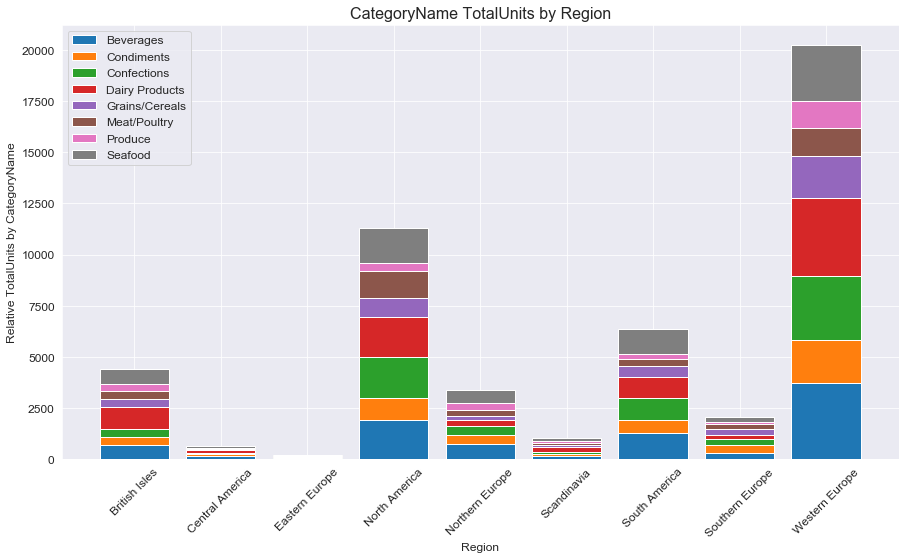

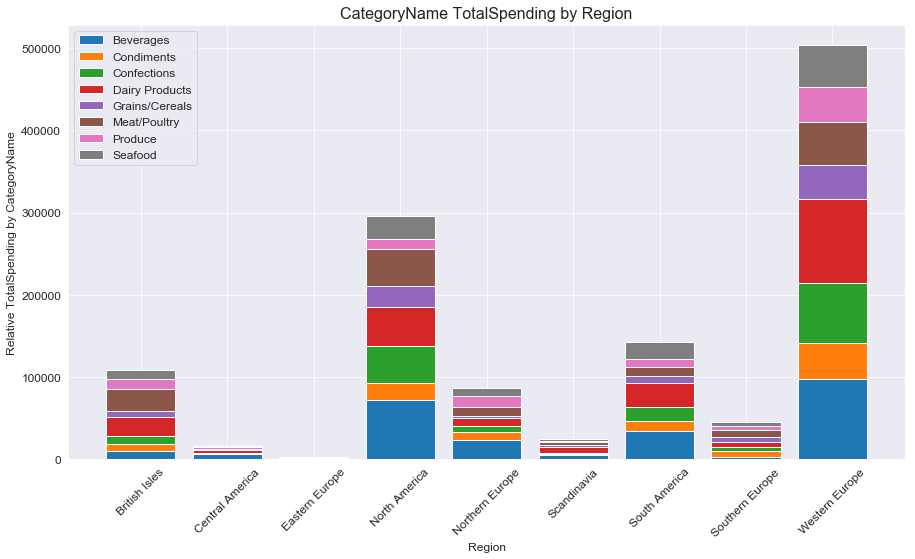

In [9]:
# Plot TotalUnits sold in each Region for each Product Category
dataset = make_dataset(region_df, 'CategoryName', 'TotalUnits')
# must add in a value for Grains/Cereals since Eastern Europe did not purchase any
dataset[4].insert(2,0)
stacked_bar_plot(region_df, 'CategoryName','Region', 'TotalUnits', dataset)

# Plot TotalSpending in each Region for each Product Category
dataset = make_dataset(region_df, 'CategoryName', 'TotalSpending')
# must add in a value for Grains/Cereals since Eastern Europe did not purchase any
dataset[4].insert(2,0)
stacked_bar_plot(region_df, 'CategoryName','Region', 'TotalSpending', dataset)

These stacked bar graphs give us a cursory idea of proportionally how much of each category every region is ordering, how much money is spent on each category, and the absolute differences in the total number of units and dollars spent by each region.

#### Grouping smaller regions

In order to work on slightly more comparable scales, we will combine the regions Eastern Europe, Northern Europe, and Scandinavia into a single region we will call "Northeastern Europe". We will also merge Central America and South America into Latin America as they share many cultural, politcal, and economic similarities.

In [10]:
region2_df = region_df.copy()

# Make our Northeastern Europe group
NE_Europe = ['Northern Europe','Eastern Europe','Scandinavia']
NE_cat_df = pd.DataFrame()
for i in list(region2_df.CategoryName.unique()):
    if NE_cat_df.empty:
        NE_cat_df = pd.DataFrame(region2_df.loc[(region2_df.CategoryName == i)
                                                & (region2_df.Region.isin(NE_Europe))]
                                 .groupby(['CategoryName'], as_index=False).sum())
    else:
        derp = pd.DataFrame(region2_df.loc[(region2_df.CategoryName == i)
                                           & (region2_df.Region.isin(NE_Europe))]
                            .groupby(['CategoryName'], as_index=False).sum())
        NE_cat_df = pd.concat([NE_cat_df, derp])
NE_cat_df.insert(1, 'Region', 'Northeastern Europe')


# Make our Latin America group
L_Amer = ['South America','Central America']
LA_cat_df = pd.DataFrame()
for i in list(region2_df.CategoryName.unique()):
    if LA_cat_df.empty:
        LA_cat_df = pd.DataFrame(region2_df.loc[(region2_df.CategoryName == i) 
                                                & (region2_df.Region.isin(L_Amer))]
                                 .groupby(['CategoryName'], as_index=False).sum())
    else:
        derp = pd.DataFrame(region2_df.loc[(region2_df.CategoryName == i)
                                           & (region2_df.Region.isin(L_Amer))]
                            .groupby(['CategoryName'], as_index=False).sum())
        LA_cat_df = pd.concat([LA_cat_df, derp])
LA_cat_df.insert(1, 'Region', 'Latin America')

In [11]:
# Concatenate new dataframes with the original one
region2_df = pd.concat([region2_df, NE_cat_df,LA_cat_df], ignore_index=True)

In [12]:
# Drop the subgroups that were merged
region2_df = region2_df.loc[~region2_df.Region.isin(list(NE_Europe + L_Amer))]
region2_df = region2_df.sort_index(by=['CategoryName', 'Region']).reset_index(drop=True)

C:\Users\Matthew Parker\.conda\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
region2_df.head(7)

,CategoryName,Region,Customers,TotalUnits,TotalSpending,TotalOrders
0,Beverages,British Isles,8,702,10421.420,35
1,Beverages,Latin America,16,1470,41334.795,74
2,Beverages,North America,14,1919,71797.035,72
3,Beverages,Northeastern Europe,8,970,29956.595,52
4,Beverages,Southern Europe,8,318,3408.540,22
5,Beverages,Western Europe,25,3732,98333.295,134
6,Condiments,British Isles,5,390,7893.550,14


### Graph data again, now with merged regions

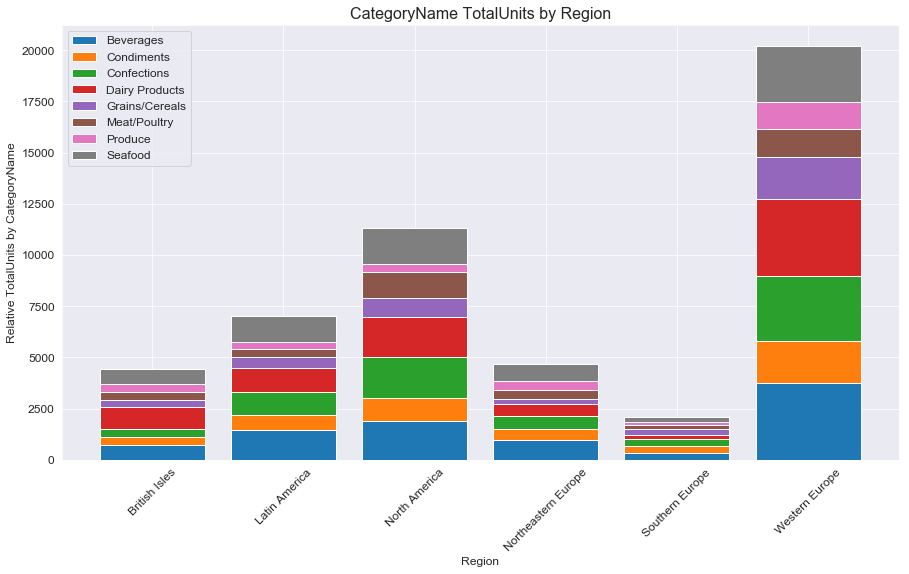

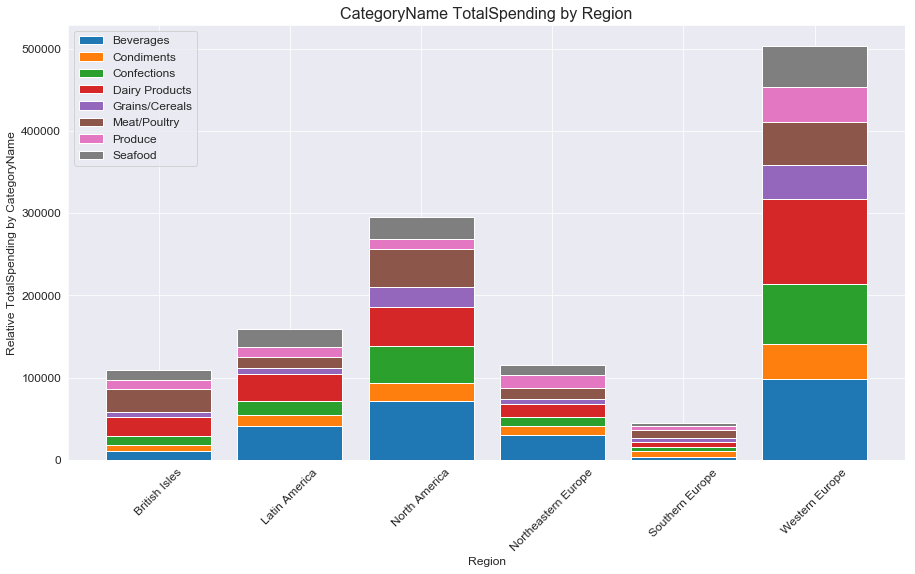

In [14]:
dataset = make_dataset(region2_df,'CategoryName', 'TotalUnits')
stacked_bar_plot(region2_df,'CategoryName', 'Region', 'TotalUnits', dataset)

dataset = make_dataset(region2_df,'CategoryName', 'TotalSpending')
stacked_bar_plot(region2_df,'CategoryName', 'Region', 'TotalSpending', dataset)

Excellent! This is much easier to interpret and compare visually. 

### Comparing Means

However, raw sums of the data is not very useful. Let's look at the customer means (dividing totals by number of customers in each region).

In [15]:
region2_df['MeanUnits'] = round(region2_df['TotalUnits'] / region2_df['Customers'], 3)
region2_df['MeanSpending'] = round(region2_df['TotalSpending'] / region2_df['Customers'], 3)
region2_df['MeanOrders'] = round(region2_df['TotalOrders'] / region2_df['Customers'], 3)
region2_df.head()

,CategoryName,Region,Customers,TotalUnits,TotalSpending,TotalOrders,MeanUnits,MeanSpending,MeanOrders
0,Beverages,British Isles,8,702,10421.420,35,87.750,1302.677,4.375
1,Beverages,Latin America,16,1470,41334.795,74,91.875,2583.425,4.625
2,Beverages,North America,14,1919,71797.035,72,137.071,5128.360,5.143
3,Beverages,Northeastern Europe,8,970,29956.595,52,121.250,3744.574,6.500
4,Beverages,Southern Europe,8,318,3408.540,22,39.750,426.068,2.750


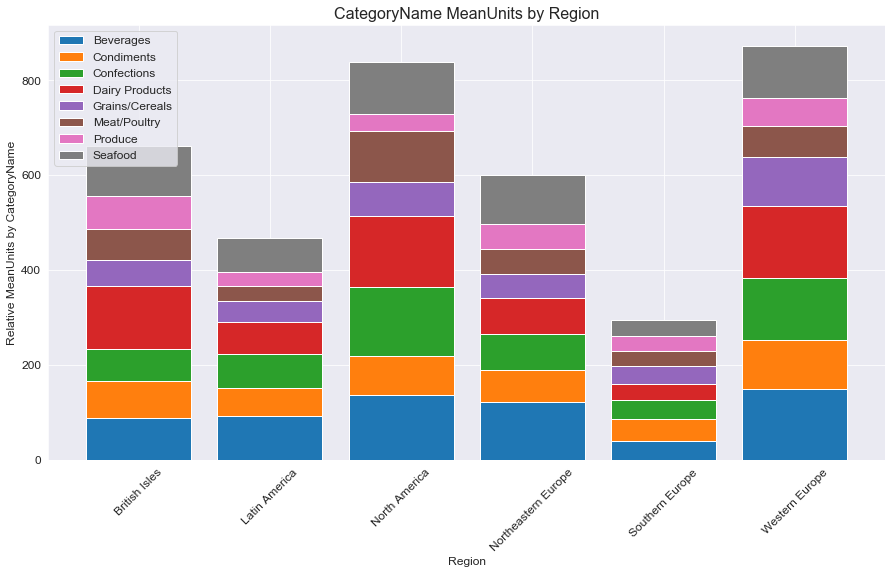

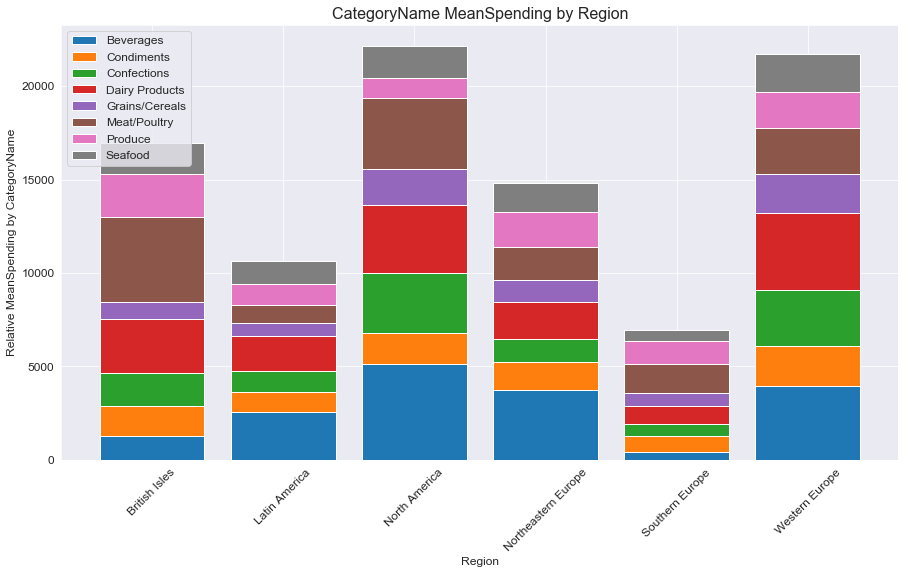

In [16]:
dataset = make_dataset(region2_df,'CategoryName', 'MeanUnits')
stacked_bar_plot(region2_df,'CategoryName', 'Region', 'MeanUnits', dataset)

dataset = make_dataset(region2_df,'CategoryName', 'MeanSpending')
stacked_bar_plot(region2_df,'CategoryName', 'Region', 'MeanSpending', dataset)

#### Do the same for the entire sample population

In [17]:
pop_df = pd.DataFrame()
for i in list(region_df.CategoryName.unique()):
    if pop_df.empty:
        pop_df = pd.DataFrame(region_df.loc[region_df.CategoryName == i]
                              .groupby(['CategoryName'], as_index=False).sum())
    else:
        derp = pd.DataFrame(region_df.loc[region_df.CategoryName == i]
                            .groupby(['CategoryName'], as_index=False).sum())
        pop_df = pd.concat([pop_df, derp])
pop_df.insert(1, 'Region', 'Western World')
pop_df['MeanUnits'] = round(pop_df['TotalUnits'] / pop_df['Customers'], 3)
pop_df['MeanSpending'] = round(pop_df['TotalSpending'] / pop_df['Customers'], 3)
pop_df['MeanOrders'] = round(pop_df['TotalOrders'] / pop_df['Customers'], 3)
pop_df.reset_index(drop=True, inplace=True)
pop_df

,CategoryName,Region,Customers,TotalUnits,TotalSpending,TotalOrders,MeanUnits,MeanSpending,MeanOrders
0,Beverages,Western World,79,9111,255251.6800,389,115.329,3231.034,4.924
1,Condiments,Western World,66,5165,103460.6850,209,78.258,1567.586,3.167
2,Confections,Western World,76,7640,161372.0600,321,100.526,2123.317,4.224
3,Dairy Products,Western World,77,8756,227335.2850,350,113.714,2952.406,4.545
4,Grains/Cereals,Western World,65,4456,93040.7375,190,68.554,1431.396,2.923
5,Meat/Poultry,Western World,66,4105,160521.1595,168,62.197,2432.139,2.545
6,Produce,Western World,61,2922,97895.3800,132,47.902,1604.842,2.164
7,Seafood,Western World,81,7560,129098.4775,319,93.333,1593.808,3.938


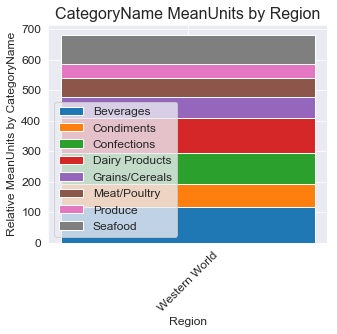

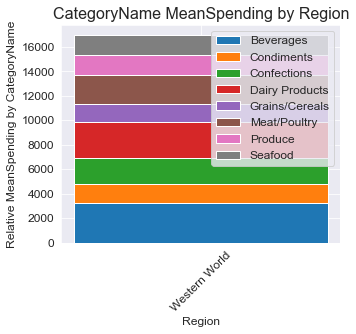

In [18]:
# Just for fun, here's two stacked bar plots of the entire sample population
dataset2 = []
for i in list(pop_df['MeanUnits'].index):
    item = []
    item.append(list(pop_df['MeanUnits'].values)[i])
    dataset2.append(item)
stacked_bar_plot(pop_df,'CategoryName', 'Region', 'MeanUnits', dataset2, figsize=(5,4))

dataset2 = []
for i in list(pop_df['MeanSpending'].index):
    item = []
    item.append(list(pop_df['MeanSpending'].values)[i])
    dataset2.append(item)
stacked_bar_plot(pop_df,'CategoryName', 'Region', 'MeanSpending', dataset2, figsize=(5,4))

## Sampling Distributions

Define the functions we need.

In [19]:
def create_sample_distribution(data, dist_size=30, n=30):
    """
    Inputs:
    - data : original dataset
    - dist_size : number of samples to generate
    - n : size of each sample
    =======================
    Returns:
    - sample distribution of sample means
    """
    sample_distr = []
    np.random.seed(37)   #so tests are reproducible
    for i in range(0,dist_size):
        sample = []
        i_list = list(np.random.randint(0,len(data),n))
        for item in i_list:
            sample.append(data[item])
        sample_distr.append(np.mean(sample))
    return sample_distr


def welch_t(a, b):
    """ Calculate Welch's t statistic for two samples. """
    numerator = np.mean(a) - np.mean(b)
    denominator = np.sqrt(np.var(a, ddof=1)/len(a) + np.var(b, ddof=1)/np.size(b))
    return abs(numerator/denominator)


def welch_df(a, b):
    """ Calculate the effective degrees of freedom for two samples. """
    num = (np.var(a, ddof=1)/np.size(a) + np.var(b, ddof=1)/np.size(b))**2
    denom = (((np.var(a, ddof=1)**2) / (((np.size(a))**2) * (np.size(a)-1))) 
             + ((np.var(b, ddof=1)**2) / (((np.size(b))**2) * (np.size(b)-1))))
    return num/denom


def p_value(a, b, two_sided=False):
    """
    Returns the p-value from a Welch's t-test given two datasets (lists, arrays, or series).
    """
    t = welch_t(a,b)
    df = welch_df(a,b)
    p = 1 - stats.t.cdf(t, df)
    if two_sided:
        p += p
    return p


def cohen_d(group1, group2):
    """
    group1: Series or NumPy array
    group2: Series or NumPy array
    returns a floating point number 
    """
    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1)
    var2 = np.var(group2)
    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = abs(diff / np.sqrt(pooled_var))    
    return d

**To proceed, we first need to make a new query that returns all individual observations instead of aggregating any information.**

In [20]:
# Make a new query that returns all observations information according to customer region and product category

c.execute("""
          SELECT cat.CategoryName, c.Region, od.Quantity, (od.Quantity*od.UnitPrice*(1-od.Discount)) as OrderPrice
          FROM OrderDetail od
          JOIN 'Order' o ON od.OrderId = o.Id
          JOIN Customer c ON o.CustomerId = c.Id
          JOIN Product p ON p.Id = od.ProductId
          JOIN Category cat ON p.CategoryId = cat.Id
          ;
          """)
population_df = pd.DataFrame(c.fetchall())
population_df.columns = [x[0] for x in c.description]
for i in ['Northern Europe','Eastern Europe','Scandinavia']:
    population_df.replace(i, 'Northeastern Europe', inplace=True)
for i in ['South America','Central America']:
    population_df.replace(i, 'Latin America', inplace=True)

display(population_df.head(6))
population_df.info()

,CategoryName,Region,Quantity,OrderPrice
0,Dairy Products,Western Europe,12,168.0
1,Grains/Cereals,Western Europe,10,98.0
2,Dairy Products,Western Europe,5,174.0
3,Produce,Western Europe,9,167.4
4,Produce,Western Europe,40,1696.0
5,Seafood,Latin America,10,77.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2078 entries, 0 to 2077
Data columns (total 4 columns):
CategoryName    2078 non-null object
Region          2078 non-null object
Quantity        2078 non-null int64
OrderPrice      2078 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 65.0+ KB


## Hypothesis Testing

Now iterate through generating sampling distributions and comparing them to the population sampling distributions on a pairwise basis, going through every ategory for every region. The outputs should be the comparison's p-value (from a Welch's t-test), effect size (Cohen's d), and statistical power (1-B).

In [27]:
sig_list = []

for region in list(population_df.Region.unique()):
    print(f'\n========================\n====={region}=====\n========================')
    for category in list(population_df.CategoryName.unique()):
        pops_df = list(population_df.loc[population_df.CategoryName == category].OrderPrice)
        reg_df = list(population_df.loc[(population_df.CategoryName == category) 
                                        & (population_df.Region == region)].OrderPrice)
        pop_samps = create_sample_distribution(pops_df, 30, 30)
        region_samps = create_sample_distribution(reg_df, 30, 30)
        p = p_value(pop_samps, region_samps, two_sided=True)
        d = cohen_d(pop_samps, region_samps)
        power = power_analysis.solve_power(effect_size=d, nobs1=len(pop_samps), alpha=.05)
        if p < 0.05 and power > 0.8:
            sig_list.append((region,category))
        print(f'{category} compared to population samples')
        print(f"Welch's t-test p-value: {p}")
        print(f"Effect size (Cohen's d): {d}")
        print(f"Statistical Power (1-B): {power}\n")


=====Western Europe=====
Dairy Products compared to population samples
Welch's t-test p-value: 0.029156875505977453
Effect size (Cohen's d): 0.5880416600924472
Statistical Power (1-B): 0.6101545807764485

Grains/Cereals compared to population samples
Welch's t-test p-value: 0.00010066474193881625
Effect size (Cohen's d): 1.098186170759709
Statistical Power (1-B): 0.9868544321844935

Produce compared to population samples
Welch's t-test p-value: 0.05151234633174351
Effect size (Cohen's d): 0.5224303020964689
Statistical Power (1-B): 0.5119428559648722

Seafood compared to population samples
Welch's t-test p-value: 0.002584819187364973
Effect size (Cohen's d): 0.8293463102382667
Statistical Power (1-B): 0.884631067402763

Condiments compared to population samples
Welch's t-test p-value: 2.0808149869822046e-08
Effect size (Cohen's d): 1.712521708228305
Statistical Power (1-B): 1.0

Confections compared to population samples
Welch's t-test p-value: 1.7930292183221397e-05
Effect size (Cohe

### Analysis

Although this iterative process generated entirely too many comparisons (40!) to produce pretty graphics for each one, all we really need to look at are the p-values, effect sizes, and statistical powers. For 75% of the comparisons, the null hypothesis was rejected at the 99% confidence level. The principle exceptions being from Western Europe or North America. This nuance can easily be explained by the fact that those two regions are responsible for the majority of the population data, so they would undertandably be more difficult to distinguish from the population means (since they so heavily influence it to begin with).

Furthermore, most of the effect sizes were very large, illustrating that a customer's region plays a very significant role in influencing how much they are likely to spend on a particular product category. 

Now that we know that region is important, let's produce some actionable information for the sales company.

#### Produce two lists

One should be a list of tuples of product category and region for places that purchase more than the population mean for that category. The other should be similar in structure, but contain instances where purchases fall below the population mean. NOTE: It is important to exclude instances where our test statistics were too weak.

In [29]:
# List of Regions where certain products are more popular and therefore should be pushed
increase_sales_push = []
for i in sig_list:
    a = region2_df.loc[(region2_df.CategoryName == i[1])
                       &(region2_df.Region == i[0])].MeanSpending
    a_prime = sum(region2_df.loc[region2_df.Region == i[0]].MeanSpending)
    b = pop_df.loc[pop_df.CategoryName == i[1]].MeanSpending
    b_prime = sum(pop_df.MeanSpending)
    if float(a)/a_prime > float(b)/b_prime:
        increase_sales_push.append((i[0],i[1]))
increase_sales_push

[('Western Europe', 'Grains/Cereals'),
 ('Western Europe', 'Condiments'),
 ('Western Europe', 'Confections'),
 ('Latin America', 'Dairy Products'),
 ('Latin America', 'Produce'),
 ('Latin America', 'Seafood'),
 ('Latin America', 'Condiments'),
 ('North America', 'Grains/Cereals'),
 ('North America', 'Confections'),
 ('North America', 'Beverages'),
 ('North America', 'Meat/Poultry'),
 ('Northeastern Europe', 'Seafood'),
 ('Northeastern Europe', 'Beverages'),
 ('Southern Europe', 'Grains/Cereals'),
 ('Southern Europe', 'Condiments'),
 ('Southern Europe', 'Meat/Poultry'),
 ('British Isles', 'Produce'),
 ('British Isles', 'Condiments'),
 ('British Isles', 'Meat/Poultry')]

In [30]:
# List of Regions where certain products are more popular and therefore should be pushed
decrease_sales_push = []
for region, category in sig_list:
    a = region2_df.loc[(region2_df.CategoryName == category)
                       &(region2_df.Region == region)].MeanSpending
    a_prime = sum(region2_df.loc[region2_df.Region == region].MeanSpending)
    b = pop_df.loc[pop_df.CategoryName == category].MeanSpending
    b_prime = sum(pop_df.MeanSpending)
    if float(a)/a_prime < float(b)/b_prime:
        decrease_sales_push.append((region,category))
decrease_sales_push

[('Western Europe', 'Seafood'),
 ('Western Europe', 'Meat/Poultry'),
 ('Latin America', 'Grains/Cereals'),
 ('Latin America', 'Confections'),
 ('Latin America', 'Meat/Poultry'),
 ('North America', 'Produce'),
 ('Northeastern Europe', 'Dairy Products'),
 ('Northeastern Europe', 'Grains/Cereals'),
 ('Northeastern Europe', 'Confections'),
 ('Northeastern Europe', 'Meat/Poultry'),
 ('Southern Europe', 'Dairy Products'),
 ('Southern Europe', 'Seafood'),
 ('Southern Europe', 'Confections'),
 ('Southern Europe', 'Beverages'),
 ('British Isles', 'Dairy Products'),
 ('British Isles', 'Grains/Cereals'),
 ('British Isles', 'Beverages')]

## Recommendations

I would recommend that salespersons readjust their sales efforts according to the table below. 

| Region | Product Categories to Market more Aggressively | Product Categories to Market Less Aggressively |
|:----- |:-----:|:-----:|
| British Isles | Condiments, Meat/Poultry, Produce | Beverages, Dairy Products, Grains/Cereals |
| Latin America | Condiments, Dairy Products, Produce, Seafood | Confections, Grains/Cereals, Meat/Poultry |
| North America | Beverages, Confections, Grains/Cereals, Meat/Poultry | Produce |
| Northeastern Europe | Beverages, Seafood | Confections, Dairy Products, Grains/Cereals, Meat/Poultry |
| Southern Europe | Condiments, Grains/Cereals, Meat/Poultry | Beverages, Confections, Dairy Products, Seafood |
| Western Europe | Condiments, Confections, Grains/Cereals | Meat/Poultry, Seafood |

These lists detail which regions spend proportionately more on certain categories as compared to the population ratios (e.g. Britain spends a higher percentage of its total wallet on condiments than the sample population does). This means that the listed product categories are in higher demand in the listed regions than one could normally expect, implying that it should be easier to sell more of those products (and possibly at a higher price) in those regions than others, especially when acquiring new customers.

However, this does not mean that existing sales of low-demand product-region combinations should be neglected to the point where they decrease. This study merely suggests that no additional effort be spent increasing those combinations.